In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("spark_sql_basic2")
sc   = SparkContext(conf=conf)

In [2]:
# RDD만을 이용한 데이터 추출

In [3]:
movies_rdd = sc.parallelize([
    (1, ("어벤져스", "마블")),
    (2, ("슈퍼맨", "DC")),
    (3, ("배트맨", "DC")),
    (4, ("겨울왕국", "디즈니")),
    (5, ("아이언맨", "마블"))
])


attendances_rdd = sc.parallelize([
    (1, (13934592, "KR")),
    (2, (2182227,"KR")),
    (3, (4226242, "KR")),
    (4, (10303058, "KR")),
    (5, (4300365, "KR"))
])

In [4]:
# 마블 영화 중 관객 수가 500만 이상인 영화를 가져오기

In [5]:
# CASE1. join 먼저, filter 나중에
movie_att = movies_rdd.join(attendances_rdd)
movie_att.filter(
    lambda x : x[1][0][1] == "마블" and x[1][1][0] > 5000000
).collect()

[(1, (('어벤져스', '마블'), (13934592, 'KR')))]

In [6]:
# CASE 2. filter 먼저, join 나중에
filtered_movies = movies_rdd.filter(lambda x : x[1][1] == '마블')
filtered_att = attendances_rdd.filter(lambda x : x[1][0] > 5000000)

filtered_movies.join(filtered_att).collect()

[(1, (('어벤져스', '마블'), (13934592, 'KR')))]

In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
# 현재 실행 중인 SparkSession 가져오기
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [8]:
spark.stop()

In [9]:
# Spark SQL 사용해 보기

In [10]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("spark-sql").getOrCreate()

In [11]:
# 컬럼 추가
movies = [
    (1, "어벤져스", "마블", 2012, 4, 26),
    (2, "슈퍼맨", "DC", 2013, 6, 13),
    (3, "배트맨", "DC", 2008, 8, 6),
    (4, "겨울왕국", "디즈니", 2014, 1, 16),
    (5, "아이언맨", "마블", 2008, 4, 30)
]

In [12]:
#스키마를 알아야 한다.
movie_schema = ["id", "name", "company", "year", "month", "day"]

In [13]:
# 2. 데이터 프레임 만들기

In [14]:
df = spark.createDataFrame(data=movies, schema=movie_schema)

In [15]:
df.dtypes

[('id', 'bigint'),
 ('name', 'string'),
 ('company', 'string'),
 ('year', 'bigint'),
 ('month', 'bigint'),
 ('day', 'bigint')]

In [16]:
print(df.show())

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  3|  배트맨|     DC|2008|    8|  6|
|  4|겨울왕국| 디즈니|2014|    1| 16|
|  5|아이언맨|   마블|2008|    4| 30|
+---+--------+-------+----+-----+---+

None


In [17]:
df.select("name").show()

+--------+
|    name|
+--------+
|어벤져스|
|  슈퍼맨|
|  배트맨|
|겨울왕국|
|아이언맨|
+--------+



In [18]:
df.select('company').show()

+-------+
|company|
+-------+
|   마블|
|     DC|
|     DC|
| 디즈니|
|   마블|
+-------+



In [19]:
df.select('year','month','day').show()

+----+-----+---+
|year|month|day|
+----+-----+---+
|2012|    4| 26|
|2013|    6| 13|
|2008|    8|  6|
|2014|    1| 16|
|2008|    4| 30|
+----+-----+---+



In [20]:
df.filter(df.year >= 2010).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
|  2|  슈퍼맨|     DC|2013|    6| 13|
|  4|겨울왕국| 디즈니|2014|    1| 16|
+---+--------+-------+----+-----+---+



In [21]:
#2010년 이후 마블영화만
df.filter((df.year>=2010) & (df.company=='마블')).show()

+---+--------+-------+----+-----+---+
| id|    name|company|year|month|day|
+---+--------+-------+----+-----+---+
|  1|어벤져스|   마블|2012|    4| 26|
+---+--------+-------+----+-----+---+



In [26]:
df.createOrReplaceTempView("movies")

In [23]:
# 영화 이름만 가져오기

query = """

SELECT name
  FROM movies

"""
spark.sql(query).show()

+--------+
|    name|
+--------+
|어벤져스|
|  슈퍼맨|
|  배트맨|
|겨울왕국|
|아이언맨|
+--------+



In [24]:
# 2010년 이후에 개봉한 영화를 조회

query = """

SELECT name
    FROM MOVIES
    WHERE year>=2010
"""
spark.sql(query).show()

+--------+
|    name|
+--------+
|어벤져스|
|  슈퍼맨|
|겨울왕국|
+--------+



In [25]:
# 2012년도 이전에 개봉한 영화의 이름과 회사를 출력
query = """

SELECT name, company
from movies
where year<2012
"""
spark.sql(query).show()

+--------+-------+
|    name|company|
+--------+-------+
|  배트맨|     DC|
|아이언맨|   마블|
+--------+-------+



In [ ]:
# like 문자열 데이터에서 특정 단어나 문장을 포함한 데이터를 찾을 때
# % 기호를 사용해서 문장이 매칭되는지 확인 가능!
# 제목이 ~~맨으로 끝나는 데이터의 모든 정보를 조회
query = """

"""
spark.sql(query).show()

In [27]:
# BETWEEN 특정 데이터와 데이터 사이를 조회

# 개봉 월이 4 ~ 8월 사이. 4 <= 개봉월 <= 8

query = """

SELECT name, month
from movies
where month between 4 and 8
"""
spark.sql(query).show()

+--------+-----+
|    name|month|
+--------+-----+
|어벤져스|    4|
|  슈퍼맨|    6|
|  배트맨|    8|
|아이언맨|    4|
+--------+-----+



## Join 구현하기

In [29]:
attendances = [
    (1, 13934592., "KR"),
    (2, 2182227.,"KR"),
    (3, 4226242., "KR"),
    (4, 10303058., "KR"),
    (5, 4300365., "KR")
]

In [30]:
# 직접 스키마 지정해 보기
from pyspark.sql.types import StringType, FloatType\
    , IntegerType\
    , StructType, StructField

In [31]:
att_schema = StructType([ # 모든 컬럼의 타입을 통칭 - 컬럼 데이터의 집합
    StructField("id", IntegerType(), True), # StructField : 컬럼
    StructField("att", FloatType(), True),
    StructField("theater_country", StringType(), True)
])

In [32]:
att_df = spark.createDataFrame(
    data=attendances,
    schema=att_schema
)

att_df.dtypes

[('id', 'int'), ('att', 'float'), ('theater_country', 'string')]

In [33]:
att_df.createOrReplaceTempView("att")

In [35]:
att_df.select('*').show()

+---+-----------+---------------+
| id|        att|theater_country|
+---+-----------+---------------+
|  1|1.3934592E7|             KR|
|  2|  2182227.0|             KR|
|  3|  4226242.0|             KR|
|  4|1.0303058E7|             KR|
|  5|  4300365.0|             KR|
+---+-----------+---------------+



In [37]:
#df와 join
query='''
select  movies.id, movies.name, movies.company, att.att
from movies
join att ON movies.id=att.id
'''
spark.sql(query).show()

+---+--------+-------+-----------+
| id|    name|company|        att|
+---+--------+-------+-----------+
|  1|어벤져스|   마블|1.3934592E7|
|  2|  슈퍼맨|     DC|  2182227.0|
|  3|  배트맨|     DC|  4226242.0|
|  4|겨울왕국| 디즈니|1.0303058E7|
|  5|아이언맨|   마블|  4300365.0|
+---+--------+-------+-----------+



In [38]:
spark.stop()

## SQL 최적화

In [43]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()

In [46]:
trip_file = "learning_spark_data/fhvhv_tripdata_2020-03.csv"

In [47]:
# inferSchema : 자동으로 스키마 예측하게 하기
data = spark.read.csv(trip_file, inferSchema=True, header=True)

In [48]:
data.createOrReplaceTempView("mobility_data")

In [49]:
query = """
select *
from mobility_data
limit 5
"""
spark.sql(query).show()

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|SR_Flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|           HV0005|              B02510|2020-03-01 00:03:40|2020-03-01 00:23:39|          81|         159|   NULL|
|           HV0005|              B02510|2020-03-01 00:28:05|2020-03-01 00:38:57|         168|         119|   NULL|
|           HV0003|              B02764|2020-03-01 00:03:07|2020-03-01 00:15:04|         137|         209|      1|
|           HV0003|              B02764|2020-03-01 00:18:42|2020-03-01 00:38:42|         209|          80|   NULL|
|           HV0003|              B02764|2020-03-01 00:44:24|2020-03-01 00:58:44|         256|         226|   NULL|
+-----------------+--------------------+-------------------+-------------------+

In [50]:
query = """

select split(pickup_datetime, ' ')[0] as pickup_date, count(*) as trips
from mobility_data

group by pickup_date
"""

spark.sql(query).show()

+-----------+------+
|pickup_date| trips|
+-----------+------+
| 2020-03-03|697880|
| 2020-03-02|648986|
| 2020-03-01|784246|
| 2020-03-06|872012|
| 2020-03-05|731165|
| 2020-03-04|707879|
| 2020-03-09|628940|
| 2020-03-08|731222|
| 2020-03-07|886071|
| 2020-03-10|626474|
| 2020-03-12|643257|
| 2020-03-11|628601|
| 2020-03-16|391518|
| 2020-03-13|660914|
| 2020-03-15|448125|
| 2020-03-14|569397|
| 2020-03-26|141607|
| 2020-03-25|141088|
| 2020-03-20|261900|
| 2020-03-24|141686|
+-----------+------+
only showing top 20 rows



In [53]:
# 실행 계획 살펴보기
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Aggregate ['pickup_date], ['split('pickup_datetime,  )[0] AS pickup_date#288, 'count(1) AS trips#289]
+- 'UnresolvedRelation [mobility_data], [], false

== Analyzed Logical Plan ==
pickup_date: string, trips: bigint
Aggregate [split(cast(pickup_datetime#215 as string),  , -1)[0]], [split(cast(pickup_datetime#215 as string),  , -1)[0] AS pickup_date#288, count(1) AS trips#289L]
+- SubqueryAlias mobility_data
   +- View (`mobility_data`, [hvfhs_license_num#213,dispatching_base_num#214,pickup_datetime#215,dropoff_datetime#216,PULocationID#217,DOLocationID#218,SR_Flag#219])
      +- Relation [hvfhs_license_num#213,dispatching_base_num#214,pickup_datetime#215,dropoff_datetime#216,PULocationID#217,DOLocationID#218,SR_Flag#219] csv

== Optimized Logical Plan ==
Aggregate [_groupingexpression#293], [_groupingexpression#293 AS pickup_date#288, count(1) AS trips#289L]
+- Project [split(cast(pickup_datetime#215 as string),  , -1)[0] AS _groupingexpression#293]
   +- Rel

In [54]:
# 두번째 쿼리
spark.sql("""select 
                pickup_date, 
                count(*) as trips
             from ( select
                          split(pickup_datetime, ' ')[0] as pickup_date
                          from mobility_data )
             group by pickup_date""").explain(True)

== Parsed Logical Plan ==
'Aggregate ['pickup_date], ['pickup_date, 'count(1) AS trips#297]
+- 'SubqueryAlias __auto_generated_subquery_name
   +- 'Project ['split('pickup_datetime,  )[0] AS pickup_date#296]
      +- 'UnresolvedRelation [mobility_data], [], false

== Analyzed Logical Plan ==
pickup_date: string, trips: bigint
Aggregate [pickup_date#296], [pickup_date#296, count(1) AS trips#297L]
+- SubqueryAlias __auto_generated_subquery_name
   +- Project [split(cast(pickup_datetime#215 as string),  , -1)[0] AS pickup_date#296]
      +- SubqueryAlias mobility_data
         +- View (`mobility_data`, [hvfhs_license_num#213,dispatching_base_num#214,pickup_datetime#215,dropoff_datetime#216,PULocationID#217,DOLocationID#218,SR_Flag#219])
            +- Relation [hvfhs_license_num#213,dispatching_base_num#214,pickup_datetime#215,dropoff_datetime#216,PULocationID#217,DOLocationID#218,SR_Flag#219] csv

== Optimized Logical Plan ==
Aggregate [pickup_date#296], [pickup_date#296, count(1) AS tri

In [ ]:
spark.stop()

In [58]:
trip_file = "fhvhv_tripdata_2020-03.csv"
zone_file = "taxi+_zone_lookup.csv"

In [59]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()

In [60]:
#운행 데이터 프레임 생성, Zone 데이터프레임 생성
trip_data = spark.read.format("csv")\
    .option("header", 'true')\
    .option('inferSchema', 'true')\
    .load('learning_spark_data/fhvhv_tripdata_2020-03.csv')
zone_data = spark.read.format("csv")\
    .option("header", 'true')\
    .option('inferSchema', 'true')\
    .load('learning_spark_data/taxi+_zone_lookup.csv')

In [61]:
trip_data.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: integer (nullable = true)



hvfhs_license_num:	차량 플랫폼(예: Uber, Lyft 등) 별로 부여된 고유 라이선스 번호  
dispatching_base_num:	차량을 배차·관리하는 업체(베이스) 식별 번호    
pickup_datetime:	승객이 차량에 탑승한(픽업한) 날짜/시간 (timestamp)  
dropoff_datetime:	승객이 하차한(드롭오프) 날짜/시간 (timestamp)  
PULocationID:	  승차지(픽업장소)의 택시존 고유번호 (NYC 공식 zone code)  
DOLocationID:	  하차지(드롭오프장소)의 택시존 고유번호 (NYC 공식 zone code)  
SR_Flag:	Shared Ride(합승) 여부 플래그 (1=합승, 0 또는 null=단독 탑승 등)  

In [62]:
zone_data.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



LocationID:	뉴욕시 공식 택시존 고유 번호 (승·하차 장소 매핑의 기준 컬럼)  
Borough:  해당 zone이 속한 뉴욕시 행정구(5개구: Manhattan, Brooklyn 등)  
Zone:	구체적 동네/구역 이름 (예: Upper East Side, JFK Airport 등)  
service_zone:	서비스 구분용 구역 그룹 (예: Yellow Zone, Boro Zone 등)  

In [64]:
##  1. 승차 Location(PULocationID)별 개수 세기  
# 2. 하차 Location(DOLocationID)별 개수 세기  
# 3.HV0003 운송사업자의 승차 지역별 트립 건수를 집계하기.    
# 4.가장 많은 운송사업자순으로 정렬하는 분석 쿼리  hvfhs_license_num    
# 5.운송사별 운행 건수 비교  
# 6. 승차 위치 Borough별 운행 건수  
# 7. 서비스 존별 승차/하차 건수  

In [80]:
#결측치 확인
from pyspark.sql.functions import col

for c in trip_data.columns:
    null_cnt = trip_data.filter(col(c).isNull()).count()
    print(f"{c}: {null_cnt}")

hvfhs_license_num: 0
dispatching_base_num: 0
pickup_datetime: 0
dropoff_datetime: 0
PULocationID: 0
DOLocationID: 0
SR_Flag: 12120323


In [65]:
#1.승차 Location(PULocationID)별 개수 세기  

trip_data.groupBy('PULocationID')\
    .count()\
    .orderBy('count',ascending=False)\
    .show()

+------------+------+
|PULocationID| count|
+------------+------+
|          61|222094|
|          79|183821|
|          76|168311|
|         132|163734|
|         138|155876|
|          37|155388|
|          42|143389|
|         231|135712|
|         234|132693|
|         161|128751|
|         244|126621|
|          17|126228|
|           7|125458|
|          89|124289|
|         225|124001|
|         170|122731|
|         230|121628|
|         181|121576|
|          48|120732|
|          39|116669|
+------------+------+
only showing top 20 rows



In [67]:
# 2. 하차 Location(DOLocationID)별 개수 세기  
trip_data.groupBy('DOLocationID')\
    .count()\
    .orderBy('count', ascending=False)\
    .show()

+------------+------+
|DOLocationID| count|
+------------+------+
|         265|387758|
|          61|224476|
|         132|216213|
|         138|194943|
|          76|172649|
|          37|158832|
|          79|147732|
|          42|136729|
|         225|128945|
|          17|128152|
|         244|127797|
|          89|126958|
|           7|124255|
|         161|121771|
|         234|118345|
|         181|116900|
|         231|116345|
|          39|113966|
|         188|113280|
|         170|109306|
+------------+------+
only showing top 20 rows



In [70]:
# 3.HV0003 운송사업자의 승차 지역별 트립 건수를 집계하기.    

hv3_pickup_count = trip_data.filter(trip_data.hvfhs_license_num == 'HV0003') \
    .groupBy('hvfhs_license_num', 'PULocationID') \
    .count() \
    .orderBy('count', ascending=False)

hv3_pickup_count.show()

+-----------------+------------+------+
|hvfhs_license_num|PULocationID| count|
+-----------------+------------+------+
|           HV0003|          61|163091|
|           HV0003|          76|134198|
|           HV0003|         132|114179|
|           HV0003|          79|112017|
|           HV0003|          37|110150|
|           HV0003|          42|108070|
|           HV0003|         138|104119|
|           HV0003|         244| 97324|
|           HV0003|          89| 95724|
|           HV0003|          39| 94484|
|           HV0003|         231| 94155|
|           HV0003|           7| 92676|
|           HV0003|          17| 90352|
|           HV0003|         161| 90261|
|           HV0003|         225| 88749|
|           HV0003|         234| 88372|
|           HV0003|         230| 86870|
|           HV0003|         188| 84347|
|           HV0003|          35| 82764|
|           HV0003|         168| 82396|
+-----------------+------------+------+
only showing top 20 rows



In [72]:
# 4.가장 많은 운송사업자순으로 정렬하는 분석 쿼리  hvfhs_license_num    

trip_data.groupBy('hvfhs_license_num')\
    .count()\
    .orderBy('count',ascending=False)\
    .show()

+-----------------+-------+
|hvfhs_license_num|  count|
+-----------------+-------+
|           HV0003|9836763|
|           HV0005|3219535|
|           HV0004| 336606|
+-----------------+-------+



In [73]:
# 5.운송사별 운행 건수 비교  

carrier_counts = trip_data.groupBy('hvfhs_license_num') \
    .count() \
    .orderBy('count', ascending=False)

carrier_counts.show()

+-----------------+-------+
|hvfhs_license_num|  count|
+-----------------+-------+
|           HV0003|9836763|
|           HV0005|3219535|
|           HV0004| 336606|
+-----------------+-------+



In [77]:
# 6. 승차 위치 Borough별 운행 건수  


trip_data.join(
    zone_data,
    trip_data.PULocationID==zone_data.LocationID,
    'left'
).groupBy('Borough')\
 .count()\
 .orderBy('count',ascending=False)\
 .show()

+-------------+-------+
|      Borough|  count|
+-------------+-------+
|    Manhattan|4953140|
|     Brooklyn|3735764|
|       Queens|2437383|
|        Bronx|2086592|
|Staten Island| 178818|
|      Unknown|    845|
|          EWR|    362|
+-------------+-------+



In [78]:
# 7. 서비스 존별 승차 건수  

trip_data.join(
    zone_data,
    trip_data.PULocationID==zone_data.LocationID,
    'left'
).groupBy('service_zone')\
 .count()\
 .orderBy('count',ascending=False)\
 .show()

+------------+-------+
|service_zone|  count|
+------------+-------+
|   Boro Zone|9046897|
| Yellow Zone|4025190|
|    Airports| 319610|
|         N/A|    845|
|         EWR|    362|
+------------+-------+



In [79]:
#7. 서비스 존별 하차 건수

trip_data.join(
    zone_data,
    trip_data.DOLocationID == zone_data.LocationID,
    'left'
).groupBy('service_zone') \
 .count() \
 .orderBy('count', ascending=False) \
 .show()

+------------+-------+
|service_zone|  count|
+------------+-------+
|   Boro Zone|8885136|
| Yellow Zone|3643787|
|    Airports| 411156|
|         N/A| 387759|
|         EWR|  65066|
+------------+-------+



## #6. 시각화 및 인사이트 도출

In [92]:
import matplotlib.font_manager as fm
for font in fm.findSystemFonts():
    if 'Nanum' in font or 'Malgun' in font or 'Apple' in font or 'DejaVu' in font or 'Gothic' in font:
        print(font)

/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf
/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf


In [95]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'  
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

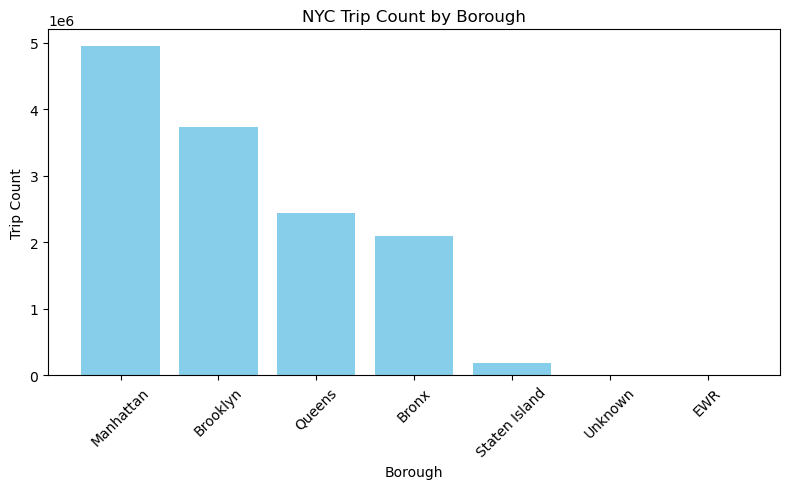

In [97]:
# 1. Spark 집계 결과를 변수에 저장
pickup_borough_count = trip_data.join(
    zone_data,
    trip_data.PULocationID == zone_data.LocationID,
    'left'
).groupBy('Borough') \
 .count() \
 .orderBy('count', ascending=False)

# 2. Pandas로 변환
pd_df = pickup_borough_count.toPandas()

# 3. Barplot 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(pd_df['Borough'], pd_df['count'], color='skyblue')
plt.title("NYC Trip Count by Borough")
plt.xlabel("Borough")
plt.ylabel("Trip Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()